<a href="https://colab.research.google.com/github/eight42910/ant-design/blob/master/pc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#インポート関連

In [ ]:
#インポート
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
#matplotlibで日本語にしたい場合は、これをinstallして、インポートする
!pip install japanize-matplotlib
import japanize_matplotlib
%matplotlib inline

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


#データ読み込みと基本情報

In [ ]:
# -------- 1. Data Loading --------
# (データの読み込みと基本統計)

# Load the datasets
train = pd.read_csv('/content/drive/MyDrive/DS_PC/PCゲーム 勝敗予測 データ.csv')
test = pd.read_csv('/content/drive/MyDrive/DS_PC/PCゲーム 勝敗予測.csv')

# データフレームにいれる
train = pd.DataFrame(train)
test = pd.DataFrame(test)

# # データの概要を確認
# print(train.info())
# print(train.head())

# # 欠損値の確認
# print(train.isnull().sum())

# # 目的変数の分布を確認
# print(train['blueWins'].value_counts())

#EDA

In [ ]:
# # -------- 2. EDA --------
# # (特徴量の分布確認、可視化、相関関係)
# # 各特徴量の分布を確認するためにプロット
# def plot_feature_distributions(data, target_column):
#     features = [col for col in data.columns if col != target_column]
#     num_features = len(features)
#     fig, axes = plt.subplots(nrows=(num_features + 2) // 3, ncols=3, figsize=(15, 5 * ((num_features + 2) // 3)))
#     axes = axes.flatten()

#     for i, feature in enumerate(features):
#         sns.histplot(data[feature], kde=True, ax=axes[i])
#         axes[i].set_title(f'Distribution of {feature}')
#     plt.tight_layout()
#     plt.show()

# # 目的変数と各特徴量の関係性を確認するためのプロット
# def plot_feature_relationships(data, target_column):
#     features = [col for col in data.columns if col != target_column]
#     num_features = len(features)
#     fig, axes = plt.subplots(nrows=(num_features + 2) // 3, ncols=3, figsize=(15, 5 * ((num_features + 2) // 3)))
#     axes = axes.flatten()

#     for i, feature in enumerate(features):
#         sns.boxplot(x=data[target_column], y=data[feature], ax=axes[i])
#         axes[i].set_title(f'{feature} vs {target_column}')
#     plt.tight_layout()
#     plt.show()

# # 特徴量同士の相関を確認
# def plot_feature_correlation(data):
#     plt.figure(figsize=(10, 8))
#     correlation_matrix = data.corr()
#     sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
#     plt.title("Feature Correlation Matrix")
#     plt.show()

# # プロットの実行
# plot_feature_distributions(train, 'blueWins')
# plot_feature_relationships(train, 'blueWins')
# plot_feature_correlation(train)


In [ ]:
#基本統計量
train.describe()

,gameId,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience,blueWins
count,8000.000000,8000.000000,8000.000000,8000.00000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,4983.683000,0.513000,6.029750,5.92350,5.881875,0.538625,0.358125,17154.067750,17983.514000,0.491750
std,2893.028418,0.499862,2.623876,2.64892,3.189897,0.629728,0.479479,1820.796171,772.348402,0.499963
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,13475.000000,16650.000000,0.000000
25%,2473.750000,0.000000,4.000000,4.00000,3.000000,0.000000,0.000000,16544.000000,17256.000000,0.000000
50%,4985.500000,1.000000,6.000000,6.00000,6.000000,0.000000,0.000000,17409.000000,18021.000000,0.000000
75%,7493.250000,1.000000,8.000000,8.00000,8.000000,1.000000,1.000000,18274.000000,18472.000000,1.000000
max,9998.000000,1.000000,14.000000,14.00000,17.000000,2.000000,1.000000,20619.000000,20101.000000,1.000000


#ベースライン

In [ ]:
# # -------- 3. Baseline Model --------
# # (ベースラインモデル：ロジスティック回帰やランダムフォレスト)

# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score

# # 特徴量と目的変数を分離
# X = train.drop(['blueWins', 'gameId'], axis=1)  # gameIdは不要なので削除
# y = train['blueWins']

# # データを訓練用と検証用に分割
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# # ロジスティック回帰モデルの初期化
# model = LogisticRegression(max_iter=1000, random_state=42) #収束しなかったのでmax_iterを1000にした

# # モデルの学習
# model.fit(X_train, y_train)

# # 検証用データで予測
# y_pred = model.predict(X_valid)

# # Accuracyの計算
# accuracy = accuracy_score(y_valid, y_pred)
# print(f'Validation Accuracy: {accuracy}')

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
# # 特徴量と目的変数の分離
# X = train.drop(columns=['gameId', 'blueWins'])  # 'gameId' は予測に使わない
# y = train['blueWins']

# # 訓練データとテストデータに分割
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# # ランダムフォレストモデルの学習
# rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
# rf_model.fit(X_train, y_train)

# # ランダムフォレストモデルの初期化
# rf_model = RandomForestClassifier(random_state=42)

# # 5分割交差検証でモデルを評価
# scores = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')

# # 各分割でのスコアと平均スコアを表示
# print(f'Cross Validation Scores: {scores}')
# print(f'Average Cross Validation Score: {np.mean(scores)}')

In [ ]:
# # 特徴量重要度の算出
# feature_importances = rf_model.feature_importances_
# feature_names = X.columns

# # 特徴量重要度をデータフレームにまとめてソート
# importance_df = pd.DataFrame({
#     'Feature': feature_names,
#     'Importance': feature_importances
# }).sort_values(by='Importance', ascending=False)

# # 特徴量重要度のプロット
# plt.figure(figsize=(10, 6))
# sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
# plt.title('Feature Importance (Random Forest)')
# plt.xlabel('Importance')
# plt.ylabel('Feature')
# plt.tight_layout()
# plt.show()

#特徴量

In [ ]:
# 例1 : GoldExperienceRatio, KillDeathRatio, blueAssists, blueDeaths, blueEliteMonsters

# 例2: blueTotalGold, KillDeathRatio, blueKills, blueAssists, blueEliteMonsters

# 例3: blueTotalExperience, KillDeathRatio, blueKills, blueAssists, blueEliteMonsters

In [ ]:
# # 特徴量エンジニアリング
# train['GoldExperienceRatio'] = train['blueTotalGold'] / (train['blueTotalExperience'] + 1e-6)
# train['KillDeathRatio'] = train['blueKills'] / (train['blueDeaths'] + 1e-6)
# train['AssistKillRatio'] = train['blueAssists'] / (train['blueKills'] + 1e-6)
# train['MonsterKillRatio'] = train['blueDragons'] / (train['blueEliteMonsters'] + 1e-6)
# # 平均キル/デス/アシスト (追加分)
# train['blueKillsAvg'] = train['blueKills'].mean()
# train['blueDeathsAvg'] = train['blueDeaths'].mean()
# train['blueAssistsAvg'] = train['blueAssists'].mean()
# # FirstBloodとドラゴンの両方を獲得したか (追加分)
# train['blueFirstBloodAndDragon'] = (train['blueFirstBlood'] == 1) & (train['blueDragons'] >= 1)

# test['GoldExperienceRatio'] = test['blueTotalGold'] / (test['blueTotalExperience'] + 1e-6)
# test['KillDeathRatio'] = test['blueKills'] / (test['blueDeaths'] + 1e-6)
# test['AssistKillRatio'] = test['blueAssists'] / (test['blueKills'] + 1e-6)
# test['MonsterKillRatio'] = test['blueDragons'] / (test['blueEliteMonsters'] + 1e-6)
# # 平均キル/デス/アシスト (追加分)
# test['blueKillsAvg'] = test['blueKills'].mean()
# test['blueDeathsAvg'] = test['blueDeaths'].mean()
# test['blueAssistsAvg'] = test['blueAssists'].mean()
# # FirstBloodとドラゴンの両方を獲得したか (追加分)
# test['blueFirstBloodAndDragon'] = (test['blueFirstBlood'] == 1) & (test['blueDragons'] >= 1)

In [ ]:
# 特徴量エンジニアリング
train['GoldExperienceRatio'] = train['blueTotalGold'] / (train['blueTotalExperience'] + 1e-6)
train['KillDeathRatio'] = train['blueKills'] / (train['blueDeaths'] + 1e-6)
train['AssistKillRatio'] = train['blueAssists'] / (train['blueKills'] + 1e-6)
train['MonsterKillRatio'] = train['blueDragons'] / (train['blueEliteMonsters'] + 1e-6)

test['GoldExperienceRatio'] = test['blueTotalGold'] / (test['blueTotalExperience'] + 1e-6)
test['KillDeathRatio'] = test['blueKills'] / (test['blueDeaths'] + 1e-6)
test['AssistKillRatio'] = test['blueAssists'] / (test['blueKills'] + 1e-6)
test['MonsterKillRatio'] = test['blueDragons'] / (test['blueEliteMonsters'] + 1e-6)


#評価関数の使いまわし

In [ ]:
# 評価関数の定義 (使い回しを想定)
def evaluate_model(model, X, y, cv=5, scoring='accuracy', return_scores=False):
    scores = cross_val_score(model, X, y, cv=cv, scoring=scoring)
    avg_score = np.mean(scores)
    if return_scores:
        return avg_score, scores
    else:
        return avg_score

#特徴量とターゲット変数の準備

In [ ]:
# 特徴量とターゲット変数の準備
X = train.drop(['gameId', 'blueWins'], axis=1)
y = train['blueWins']
X_test = test.drop(['gameId'], axis=1)


#スケーリング

In [ ]:
# スケーリング (MinMaxScalerを使用)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

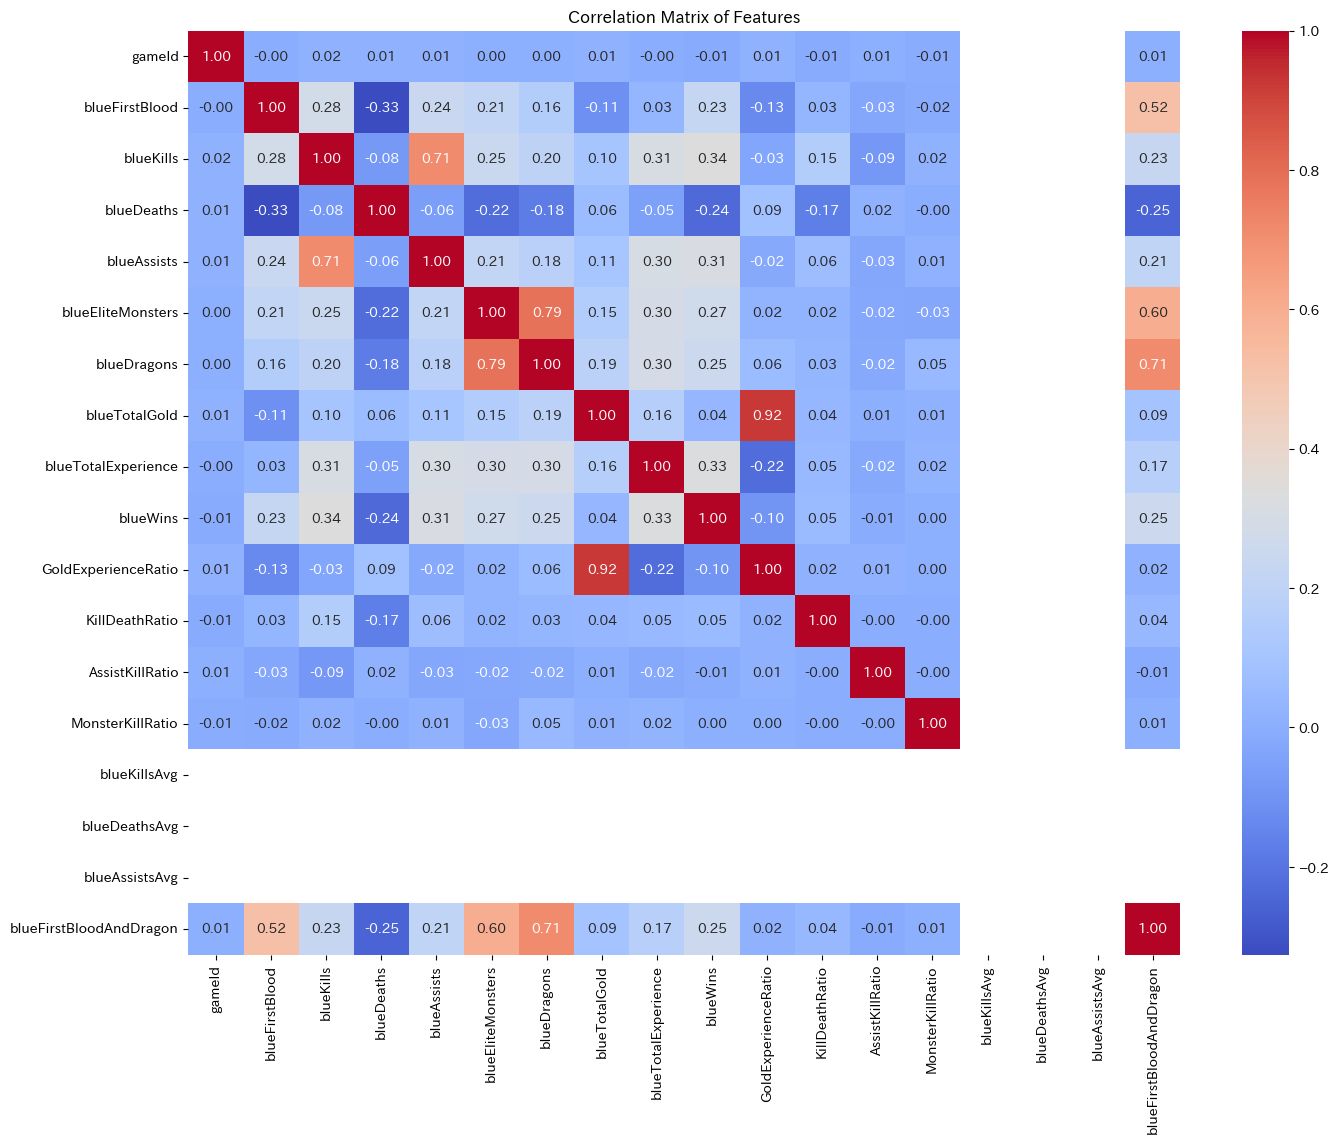

In [ ]:
# # 相関行列の計算
# correlation_matrix = train.corr()

# # ヒートマップの作成
# plt.figure(figsize=(16, 12))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
# plt.title('Correlation Matrix of Features')
# plt.show()

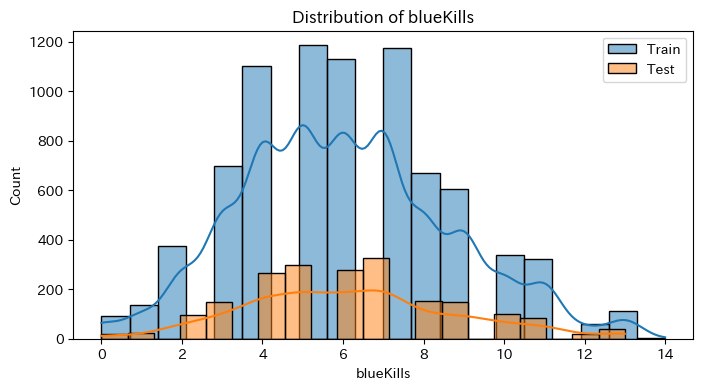

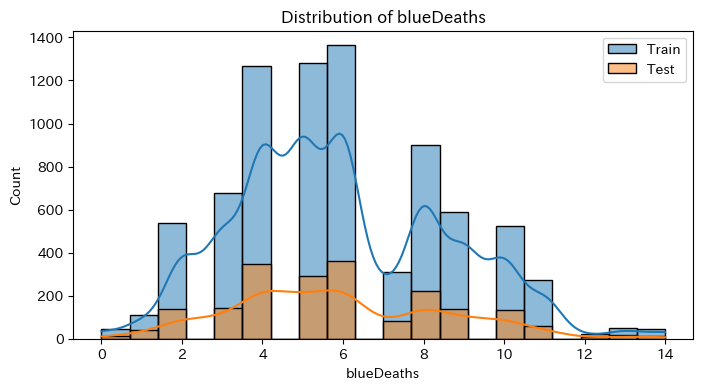

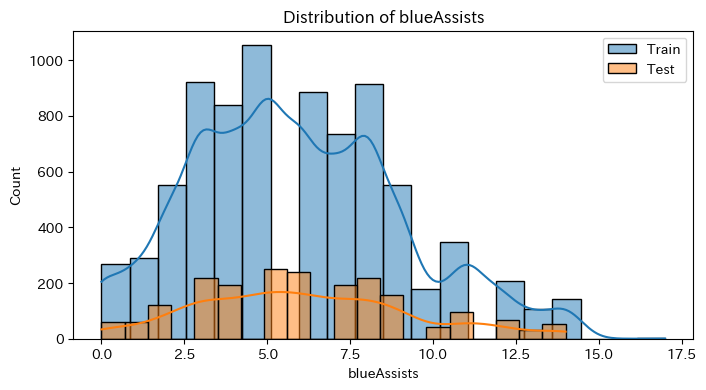

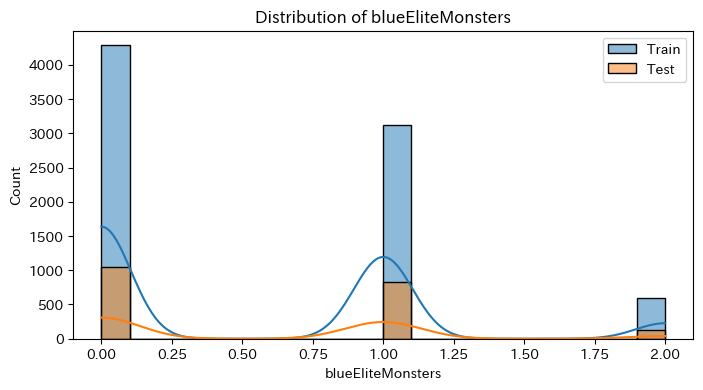

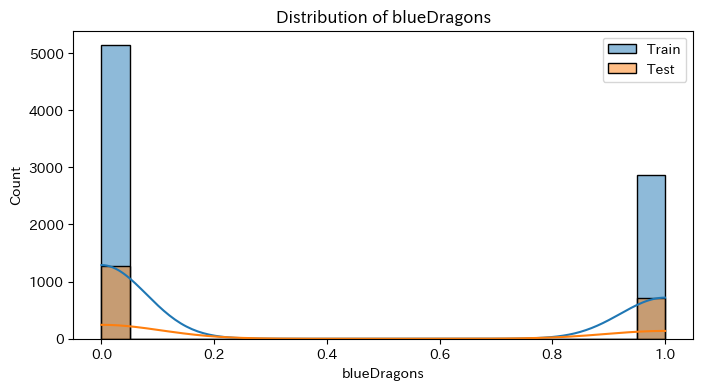

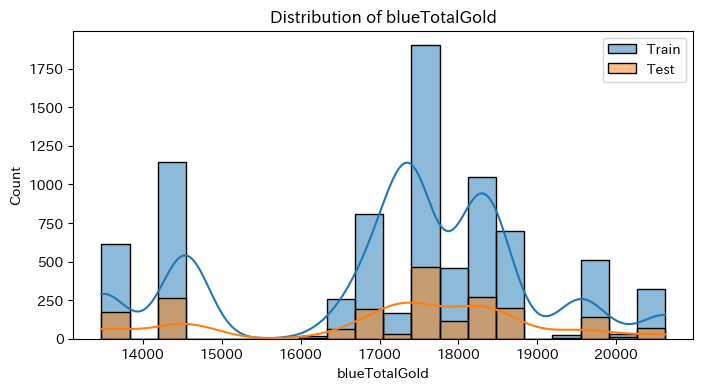

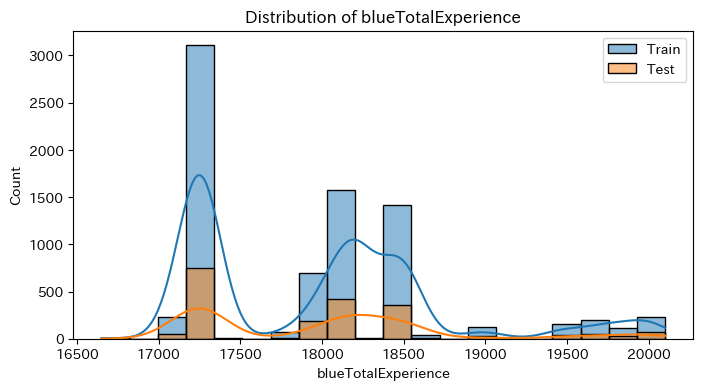

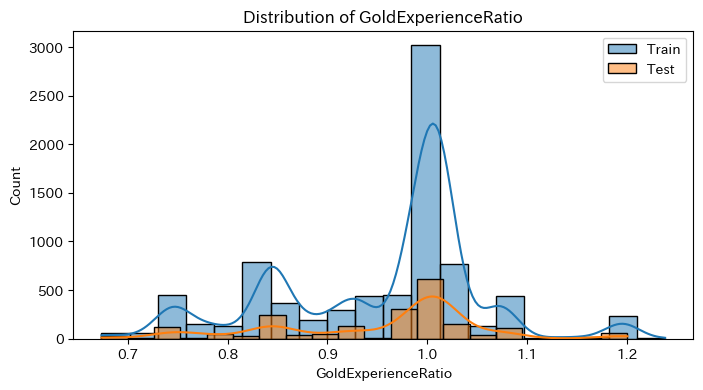

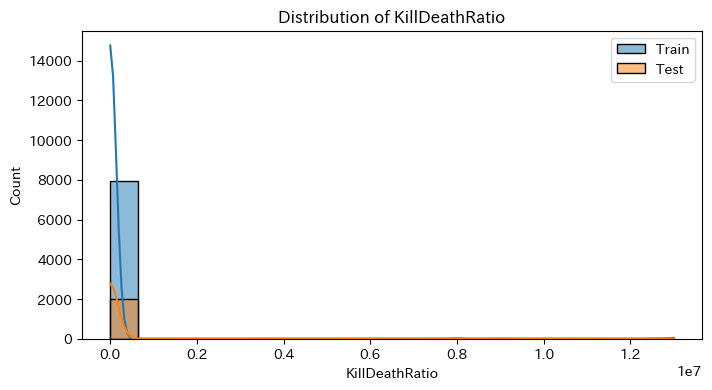

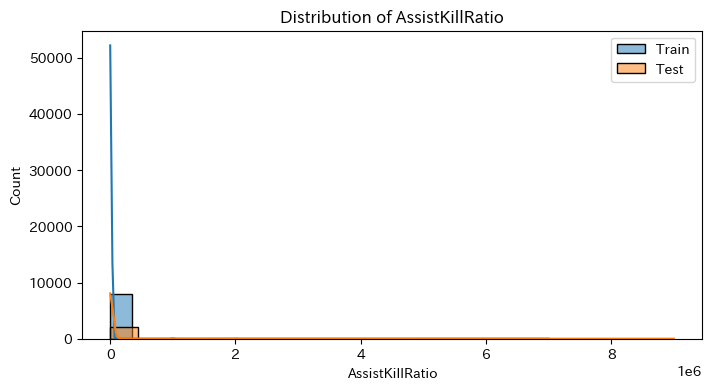

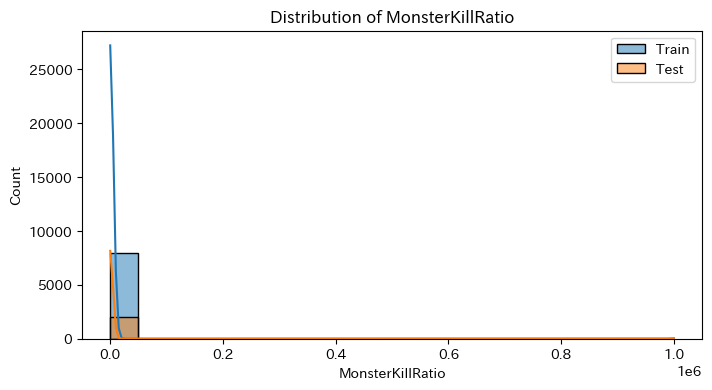

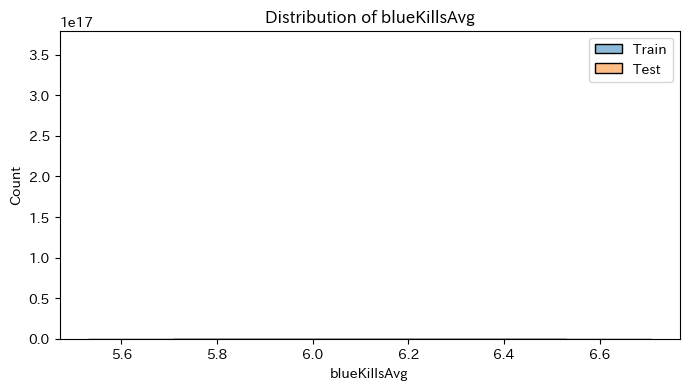

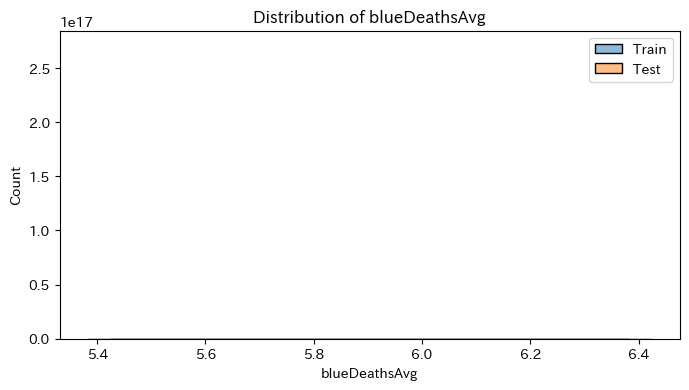

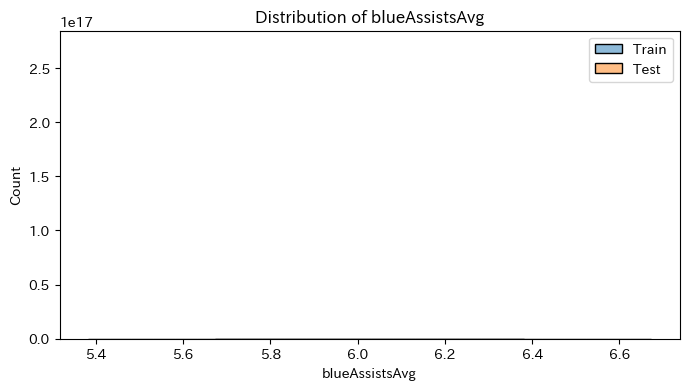

In [ ]:
# # 数値データの分布を可視化 (ヒストグラム)
# numerical_features = ['blueKills', 'blueDeaths', 'blueAssists', 'blueEliteMonsters', 'blueDragons',
#                      'blueTotalGold', 'blueTotalExperience', 'GoldExperienceRatio', 'KillDeathRatio',
#                      'AssistKillRatio', 'MonsterKillRatio', 'blueKillsAvg', 'blueDeathsAvg', 'blueAssistsAvg']
# for feature in numerical_features:
#     plt.figure(figsize=(8, 4))
#     sns.histplot(train[feature],bins=20 , label='Train', kde=True)
#     sns.histplot(test[feature], bins=20 ,label='Test', kde=True)
#     plt.title(f'Distribution of {feature}')
#     plt.legend()
#     plt.show()


#パラメータ調整とCV

In [ ]:
# from sklearn.model_selection import GridSearchCV

# # パラメータグリッド (範囲を狭める)
# param_grid = {
#     'learning_rate': [0.02, 0.025, 0.03],
#     'num_leaves': [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
# }

# # モデル (現状のベストパラメータを基に、一部固定)
# model = LGBMClassifier(
#     random_state=42,
#     max_depth=4,
#     min_child_samples=40,
#     n_estimators=800,
#     reg_alpha=0.2,
#     reg_lambda=0.2
# )

# # グリッドサーチ (CV=5)
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
# grid_search.fit(X_scaled, y)

# # ベストパラメータとスコアの表示
# print("Best Parameters:", grid_search.best_params_)
# print("Best Cross Validation Score:", grid_search.best_score_)

Fitting 5 folds for each of 33 candidates, totalling 165 fits
[LightGBM] [Info] Number of positive: 3934, number of negative: 4066
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 517
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.491750 -> initscore=-0.033003
[LightGBM] [Info] Start training from score -0.033003
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

In [ ]:
# パラメータを固定
best_params = {
    'random_state': 42,
    'learning_rate': 0.025,
    'max_depth': 4,
    'min_child_samples': 40,
    'n_estimators': 800,
    'reg_alpha': 0.2,
    'reg_lambda': 0.2,
    'num_leaves': 20
}

cv_scores = []
for i in range(10):  # 10回繰り返す
    # random_state を変更
    best_params['random_state'] = i
    # モデルの学習と評価
    model = LGBMClassifier(**best_params)
    cv_score = evaluate_model(model, X_scaled, y)
    cv_scores.append(cv_score)
    print(f"random_state={i}, CV Score: {cv_score}")

# 平均と標準偏差の算出
avg_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)

print(f"Average CV Score: {avg_cv_score}")
print(f"Standard Deviation of CV Score: {std_cv_score}")

ストリーミング出力は最後の 5000 行に切り捨てられました。
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

#実験管理

In [ ]:
# クラスを使った実験管理
class Experiment:
    def __init__(self, model_name, parameters, features, notes=""):
        self.model_name = model_name
        self.parameters = parameters
        self.features = features
        self.notes = notes
        self.cv_score = 0.0
        self.test_score = 0.0
        self.model = None

    def train_and_evaluate(self, X, y, cv=5, scoring='accuracy'):
        if self.model_name == 'LGBMClassifier':
            self.model = LGBMClassifier(**self.parameters)
        elif self.model_name == 'XGBClassifier':
            self.model = xgb.XGBClassifier(**self.parameters)
        elif self.model_name == 'RandomForestClassifier':
            self.model = RandomForestClassifier(**self.parameters)
        else:
            raise ValueError(f"Unsupported model: {self.model_name}")

        self.cv_score = evaluate_model(self.model, X, y, cv=cv, scoring=scoring)
        self.model.fit(X,y)
        return self.cv_score

    def predict(self, X_test):
        if self.model is not None:
            return self.model.predict(X_test)
        else:
            raise Exception("Model not trained yet.")


In [ ]:
# 実験の記録
experiments = []

#実験1

In [ ]:
# 実験1: ベースラインモデル (LightGBM)
exp1 = Experiment(
    model_name='LGBMClassifier',
    parameters={
        'random_state': 42,
        'learning_rate': 0.05,
        'max_depth': 3,
        'min_child_samples': 50,
        'n_estimators': 700,
        'reg_alpha': 0.1,
        'reg_lambda': 0.1
    },
    features=list(X.columns),
    notes='Baseline (LightGBM)'
)
exp1.train_and_evaluate(X_scaled, y)
experiments.append(exp1)

[LightGBM] [Info] Number of positive: 3148, number of negative: 3252
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000689 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 489
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.491875 -> initscore=-0.032503
[LightGBM] [Info] Start training from score -0.032503
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

#実験2

In [ ]:
# 実験2: 特徴量エンジニアリング後 (LightGBM) + num_leaves調整
exp2 = Experiment(
    model_name='LGBMClassifier',
    parameters={
        'random_state': 42,
        'learning_rate': 0.025,
        'max_depth': 4,
        'min_child_samples': 40,
        'n_estimators': 800,
        'reg_alpha': 0.2,
        'reg_lambda': 0.2,
        'num_leaves': 20
    },
    features=list(X.columns),
    notes='Feature Engineered (LightGBM) + num_leaves'
)
exp2.train_and_evaluate(X_scaled, y)
experiments.append(exp2)

[LightGBM] [Info] Number of positive: 3148, number of negative: 3252
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000616 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 489
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.491875 -> initscore=-0.032503
[LightGBM] [Info] Start training from score -0.032503
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

#実験3

In [ ]:
# # 実験3: XGBoostモデル
# exp3 = Experiment(
#     model_name='XGBClassifier',
#     parameters={
#         'objective': 'binary:logistic',
#         'learning_rate': 0.05,
#         'n_estimators': 700,
#         'max_depth': 3,
#         'min_child_weight': 50,
#         'reg_alpha': 0.1,
#         'reg_lambda': 0.1,
#         'random_state': 42,
#         'use_label_encoder': False,
#         'eval_metric': 'logloss'
#     },
#     features=list(X.columns),
#     notes='XGBoost'
# )
# exp3.train_and_evaluate(X_scaled, y)
# experiments.append(exp3)


AttributeError: 'super' object has no attribute '__sklearn_tags__'

#実験4

In [ ]:
# 実験4: ランダムフォレスト
exp4 = Experiment(
    model_name='RandomForestClassifier',
    parameters={
        'random_state': 42,
        'n_estimators': 100
    },
    features=list(X.columns),
    notes='RandomForest'
)
exp4.train_and_evaluate(X_scaled, y)
experiments.append(exp4)

Experiment: Baseline (LightGBM)
  Model: LGBMClassifier
  Parameters: {'random_state': 42, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_samples': 50, 'n_estimators': 700, 'reg_alpha': 0.1, 'reg_lambda': 0.1}
  Features: ['blueFirstBlood', 'blueKills', 'blueDeaths', 'blueAssists', 'blueEliteMonsters', 'blueDragons', 'blueTotalGold', 'blueTotalExperience', 'GoldExperienceRatio', 'KillDeathRatio', 'AssistKillRatio', 'MonsterKillRatio']
  CV Score: 0.784
--------------------
Experiment: Feature Engineered (LightGBM) + num_leaves
  Model: LGBMClassifier
  Parameters: {'random_state': 42, 'learning_rate': 0.025, 'max_depth': 4, 'min_child_samples': 40, 'n_estimators': 800, 'reg_alpha': 0.2, 'reg_lambda': 0.2, 'num_leaves': 20}
  Features: ['blueFirstBlood', 'blueKills', 'blueDeaths', 'blueAssists', 'blueEliteMonsters', 'blueDragons', 'blueTotalGold', 'blueTotalExperience', 'GoldExperienceRatio', 'KillDeathRatio', 'AssistKillRatio', 'MonsterKillRatio']
  CV Score: 0.7848750000000001
----

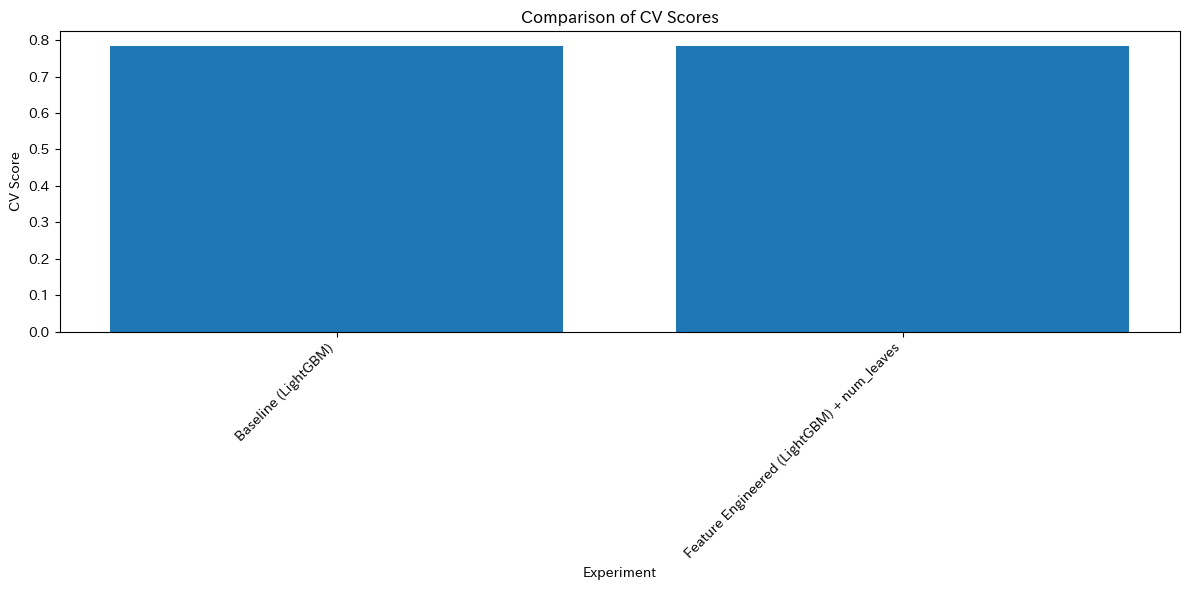

In [ ]:
# 予測結果出力
# 最終モデルを選択
final_model_exp = exp2  # 例：実験2を最終モデルとする

# 最終モデルで予測
test_predictions = final_model_exp.predict(X_test_scaled)

# 提出用データの作成
submission = pd.DataFrame({'gameId': test['gameId'], 'blueWins': test_predictions})
submission.to_csv('submission.csv', index=False, header=False)

# 実験結果の出力
for exp in experiments:
    print(f"Experiment: {exp.notes}")
    print(f"  Model: {exp.model_name}")
    print(f"  Parameters: {exp.parameters}")
    print(f"  Features: {exp.features}")
    print(f"  CV Score: {exp.cv_score}")
    print("-" * 20)

# 可視化 (例: CVスコアの比較)
cv_scores = [exp.cv_score for exp in experiments]
labels = [exp.notes for exp in experiments]

plt.figure(figsize=(12, 6))
plt.bar(labels, cv_scores)
plt.xlabel("Experiment")
plt.ylabel("CV Score")
plt.title("Comparison of CV Scores")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#最終モデル調整(LightGBM)
今回は、パラメーターの微調整により精度向上。
。


*   ゆっくりと学習
*   深さも2から3へ
*   サンプル数は70から50。
*   L1とL2も0.1から0,2






#クロスバリデーションにより、汎化性能を確認

In [ ]:
# # 元の特徴量セットに戻す
# X = train.drop(columns=['gameId', 'blueWins'])
# y = train['blueWins']

# X_test = test.drop(columns=['gameId'])

# # モデルの定義と学習
# final_model = LGBMClassifier(
#     learning_rate=0.05,
#     max_depth=3,
#     min_child_samples=50,
#     n_estimators=700,
#     reg_alpha=0.1,
#     reg_lambda=0.1,
#     random_state=42
# )

# # クロスバリデーションスコアの計算
# cv_scores = cross_val_score(final_model, X, y, cv=5, scoring='accuracy')

# # クロスバリデーション結果の確認
# print("Cross Validation Scores:", cv_scores)
# print("Average Cross Validation Score:", np.mean(cv_scores))

In [ ]:
# from sklearn.preprocessing import StandardScaler, MinMaxScaler
# from sklearn.model_selection import cross_val_score

# # データの準備（特徴量エンジニアリング後）
# X = train.drop(['gameId', 'blueWins'], axis=1)
# y = train['blueWins']

# # スケーリングなしのベースライン
# model_no_scaling = LGBMClassifier(random_state=42, **best_params)  # best_paramsは以前のグリッドサーチで得られた最適なパラメータ
# scores_no_scaling = cross_val_score(model_no_scaling, X, y, cv=5, scoring='accuracy')
# print(f"No Scaling CV Scores: {scores_no_scaling}")
# print(f"No Scaling Average CV Score: {np.mean(scores_no_scaling)}")

# # StandardScaler
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
# model_standard_scaling = LGBMClassifier(random_state=42, **best_params)
# scores_standard_scaling = cross_val_score(model_standard_scaling, X_scaled, y, cv=5, scoring='accuracy')
# print(f"StandardScaler CV Scores: {scores_standard_scaling}")
# print(f"StandardScaler Average CV Score: {np.mean(scores_standard_scaling)}")

# # MinMaxScaler
# scaler = MinMaxScaler()
# X_scaled = scaler.fit_transform(X)
# model_minmax_scaling = LGBMClassifier(random_state=42, **best_params)
# scores_minmax_scaling = cross_val_score(model_minmax_scaling, X_scaled, y, cv=5, scoring='accuracy')
# print(f"MinMaxScaler CV Scores: {scores_minmax_scaling}")
# print(f"MinMaxScaler Average CV Score: {np.mean(scores_minmax_scaling)}")

In [ ]:
# from sklearn.model_selection import cross_val_score

# def evaluate_model(model, X, y, cv=5, scoring='accuracy', return_scores=False):
#     """
#     モデルをクロスバリデーションで評価する関数

#     Args:
#         model: 評価するモデル (sklearnのestimatorインターフェースを持つ)
#         X: 特徴量データ (DataFrame or ndarray)
#         y: ターゲット変数 (Series or ndarray)
#         cv: クロスバリデーションの分割数 (int)
#         scoring: 評価指標 (str)
#         return_scores: 各分割のスコアを返すかどうか (bool)

#     Returns:
#         クロスバリデーションスコアの平均 (float)
#         (return_scores=Trueの場合) 各分割のスコア (ndarray)
#     """
#     scores = cross_val_score(model, X, y, cv=cv, scoring=scoring)
#     avg_score = np.mean(scores)

#     if return_scores:
#         return avg_score, scores
#     else:
#         return avg_score

In [ ]:
# from sklearn.metrics import confusion_matrix, classification_report

# # 学習データでの予測
# y_pred = final_model.predict(X)

# # 混同行列の表示
# print("Confusion Matrix:")
# print(confusion_matrix(y, y_pred))

# # クラスごとの詳細レポート
# print("\nClassification Report:")
# print(classification_report(y, y_pred))

# # 誤分類データの抽出
# misclassified = train[y != y_pred]
# print("\nMisclassified Samples:")
# print(misclassified.head())

#final予測、提出

In [ ]:
# # 予測の実行
# test_predictions = final_model.predict(X_test)

# # 提出用データの作成（ヘッダーなしで保存）
# submission = pd.DataFrame({'gameId': test['gameId'], 'blueWins': test_predictions})
# submission.to_csv('submission.csv', index=False, header=False)

# print("Submission file saved as 'submission.csv' without headers")


In [ ]:
# import matplotlib.pyplot as plt
# from sklearn.model_selection import learning_curve

# # 学習曲線の計算
# train_sizes, train_scores, test_scores = learning_curve(
#     final_model, X, y, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10), random_state=42)

# # スコアの平均と標準偏差
# train_mean = np.mean(train_scores, axis=1)
# train_std = np.std(train_scores, axis=1)
# test_mean = np.mean(test_scores, axis=1)
# test_std = np.std(test_scores, axis=1)

# # 学習曲線の描画
# plt.figure(figsize=(10, 6))
# plt.plot(train_sizes, train_mean, label="Training Score", color="blue")
# plt.plot(train_sizes, test_mean, label="Validation Score", color="orange")
# plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)
# plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="orange", alpha=0.2)
# plt.title("Learning Curve")
# plt.xlabel("Training Set Size")
# plt.ylabel("Accuracy")
# plt.legend()
# plt.tight_layout()
# plt.show()


#予測と提出

In [ ]:
# # テストデータで予測
# test_predictions = model.predict(test.drop('gameId', axis=1))

# # 提出ファイルの作成
# submission = pd.DataFrame({'gameId': test['gameId'], 'blueWins': test_predictions})
# submission.to_csv('submission.csv', index=False, header=False)